<a href="https://colab.research.google.com/github/bibisbar/vae-inn-synthesis-prober/blob/main/inn_vqgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

WIKI:

- INN module:https://github.com/ELIFE-ASU/INNLab/wiki
- Latent diffusion:https://github.com/CompVis/latent-diffusion
- ckpt of autoencoder:https://ommer-lab.com/files/latent-diffusion/kl-f8.zip or use [diffusers](https://huggingface.co/docs/diffusers/v0.3.0/en/api/models#diffusers.AutoencoderKL)
- dataset [cifar100](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR100.html)

Tutorial of INN

https://www.youtube.com/watch?v=IpbeIwSr7r0&ab_channel=PaulHand

https://www.youtube.com/watch?v=WqP45Iyvd3o&ab_channel=heidelberg.ai


In [ ]:
#@title Initialize INN and Autoencoder from VQGAN
!git clone https://github.com/ELIFE-ASU/INNLab
!git clone https://github.com/CompVis/taming-transformers
%cd INNLab/
!python setup.py install
%cd ..

Cloning into 'INNLab'...
remote: Enumerating objects: 830, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 830 (delta 81), reused 71 (delta 35), pack-reused 682
Receiving objects: 100% (830/830), 346.36 KiB | 5.59 MiB/s, done.
Resolving deltas: 100% (492/492), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1342 (delta 0), reused 1 (delta 0), pack-reused 1340
Receiving objects: 100% (1342/1342), 409.77 MiB | 14.20 MiB/s, done.
Resolving deltas: 100% (282/282), done.
/content/INNLab
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
    

In [ ]:
#@title Environment
!pip install --upgrade diffusers transformers scipy pytorch-lightning
!pip install omegaconf>=2.0.0 torch==1.13.1 torchvision torchdata torchtext pytorch-lightning>=1.0.8 einops>=0.3.0 accelerate normflows
!pip uninstall -y torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 64.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires t

In [ ]:
import sys
sys.path.append(".")

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!git clone https://github.com/ELIFE-ASU/INNLab
%cd INNLab/
!python setup.py install
import INN

fatal: destination path 'INNLab' already exists and is not an empty directory.
/content/INNLab
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.

# Stable Diffusion Encoder/Decoder

##### Sample Encoding/Decoding

In [ ]:
!pip install diffusers
from diffusers.models import AutoencoderKL
from diffusers import StableDiffusionPipeline
import torch

# Initialize the VAE of Stable Diffusion model using the pretrained weights.
# TODO: use the encoder and decoder of sd, not vq
sd_vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(DEVICE)
sd_vae.eval()

img = torch.randn(size=(1,3,32,32)).to(DEVICE)
latent_output = sd_vae.tiled_encode(x=img)

#encoder = sd_vae.encoder.to(DEVICE)
#encoder.eval() # Turn on evaluation mode
#latent = encoder(img)
#encoder
#latent.shape

decoded_output = sd_vae.tiled_decode(z=latent_output.latent_dist.sample())

#model = "CompVis/stable-diffusion-v1-4"
#pipe = StableDiffusionPipeline.from_pretrained(model, vae=vae)
#pipe = pipe.to("cuda")

In [ ]:
latent_output.latent_dist.sample().shape

torch.Size([1, 4, 4, 4])

In [ ]:
decoded_output.sample.shape

torch.Size([1, 3, 32, 32])

In [ ]:
from numpy.core.fromnumeric import var
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
import numpy as np
import INN

transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = datasets.CIFAR100(root='data', train=True,
                              download=True, transform=transform)
val_set = datasets.CIFAR100(root='data', train=False,
                              download=True, transform=transform)

class VariationalEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.sd_vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
        self.sd_vae.eval()
    def forward(self,x):
        latent_output = sd_vae.tiled_encode(x)
        return latent_output.latent_dist.sample()

class InnModel(pl.LightningModule):
    def __init__(self) :
        super().__init__()
        self.latent_dim = 2
        self.mu = INN.Sequential(INN.Nonlinear(64, 'RealNVP', k=self.latent_dim), INN.Nonlinear(64, 'RealNVP', k=self.latent_dim))
        self.sigma = INN.Sequential(INN.Nonlinear(64, 'RealNVP', k=self.latent_dim), INN.Nonlinear(64, 'RealNVP', k=self.latent_dim))
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
    def forward(self,x):
        mean_out, _, _ = self.mu(x)
        var_out, _, _ = self.sigma(x)
        return self.sig(mean_out) , self.sig(var_out)

class VaeInnModel(pl.LightningModule):
    def __init__(self) :
        super().__init__()
        self.sd_vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
        #self.sd_vae.eval()
        self.BATCH_SIZE = 8
        #Magic number
        self.scale_factor = 0.18215
        # Initialize three parts
        self.encoder = VariationalEncoder()
        self.flatten = nn.Flatten()
        self.innmodule = InnModel()

        # Initialize a 'target' normal distribution for KL divergence
        self.norm = torch.distributions.Normal(0, 1)
    def forward(self, x):
        z_sample = self.encoder(x)
        z_flatten = self.flatten(z_sample*self.scale_factor)
        mean_flatten,var_flatten = self.innmodule(z_flatten)
        mean_sample = mean_flatten.reshape(z_sample.shape)
        var_sample = var_flatten.reshape(z_sample.shape)

        #Get sample from norm distribution
        norm_sample = self.norm.sample(mean_sample.shape).to(DEVICE)

        #Reparalization
        inn_sample =  var_sample * norm_sample + mean_sample

        return inn_sample, mean_sample, var_sample

    def training_step(self, batch, batch_idx):
        image, label = batch
        latent_output, mean , var = self(image)

        #image_rec = sd_vae.tiled_decode(latent_output).sample

        #Compute kl loss
        kl_loss = (0.5 * (var ** 2) + 0.5 * (mean ** 2) - torch.log(var) - 0.5).sum()
        self.log("train_kl_loss", kl_loss)
        #Compute reconstruction loss
        #rec_loss = ((image - image_rec)**2).sum()
        #self.log("train_rec_loss", rec_loss)
        #loss = kl_loss + rec_loss
        loss = kl_loss  #remove rec loss
        #Logs
        self.log("train_total_loss", loss)
        print(loss)
        return loss

    def validation_step(self, batch, batch_idx):
        image, label = batch
        latent_output, mean , var = self(image)

        #image_rec = sd_vae.tiled_decode(latent_output).sample

        #Compute kl loss
        kl_loss = (0.5 * (var ** 2) + 0.5 * (mean ** 2) - torch.log(var) - 0.5).sum()
        self.log("val_kl_loss", kl_loss)
        #Compute reconstruction loss
        #rec_loss = ((image - image_rec)**2).sum()
        #self.log("val_rec_loss", rec_loss)
        #loss = kl_loss + rec_loss
        loss = kl_loss  #remove rec loss
        #Logs
        self.log("val_total_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        image, label = batch
        latent_output, mean , var = self(image)

        #image_rec = sd_vae.tiled_decode(latent_output).sample

        #Compute kl loss
        kl_loss = (0.5 * (var ** 2) + 0.5 * (mean ** 2) - torch.log(var) - 0.5).sum()
        self.log("test_kl_loss", kl_loss)
        #Compute reconstruction loss
        #rec_loss = ((image - image_rec)**2).sum()
        #self.log("test_rec_loss", rec_loss)
        #loss = kl_loss + rec_loss
        loss = kl_loss  #remove rec loss
        #Logs
        self.log("test_total_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

# Example usage
# Assuming you have train_dataset and val_dataset as torch.utils.data.Dataset objects

model = VaeInnModel()
train_loader = DataLoader(train_set, batch_size=model.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=model.BATCH_SIZE)

if DEVICE == 'cpu':
  devices = 0
else:
  devices = 1
trainer = pl.Trainer(max_epochs=1, devices=devices)  # Set devices=1 for GPU training

# Start training
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | sd_vae    | AutoencoderKL      | 83.7 M
1 | encoder   | VariationalEncoder | 83.7 M
2 | flatten   | Flatten            | 0     
3 | innmodule | InnModel           | 264 K 
-------------------------------------------------
167 M     Trainable params
0         Non-trainable params
167 M     Total params
670.290   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

tensor(281.3767, device='cuda:0', grad_fn=<SumBackward0>)
tensor(271.3380, device='cuda:0', grad_fn=<SumBackward0>)
tensor(268.3920, device='cuda:0', grad_fn=<SumBackward0>)
tensor(254.6314, device='cuda:0', grad_fn=<SumBackward0>)
tensor(229.4486, device='cuda:0', grad_fn=<SumBackward0>)
tensor(240.4151, device='cuda:0', grad_fn=<SumBackward0>)
tensor(248.7822, device='cuda:0', grad_fn=<SumBackward0>)
tensor(208.9075, device='cuda:0', grad_fn=<SumBackward0>)
tensor(158.0862, device='cuda:0', grad_fn=<SumBackward0>)
tensor(193.4676, device='cuda:0', grad_fn=<SumBackward0>)
tensor(154.0646, device='cuda:0', grad_fn=<SumBackward0>)
tensor(218.3093, device='cuda:0', grad_fn=<SumBackward0>)
tensor(147.3857, device='cuda:0', grad_fn=<SumBackward0>)
tensor(149.2990, device='cuda:0', grad_fn=<SumBackward0>)
tensor(90.0163, device='cuda:0', grad_fn=<SumBackward0>)
tensor(71.6158, device='cuda:0', grad_fn=<SumBackward0>)
tensor(157.1087, device='cuda:0', grad_fn=<SumBackward0>)
tensor(67.9785, 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Invertible NNs Tutorial

In [ ]:

import INN
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

import numpy as np

In [ ]:
class half_circle(data.Dataset):
    r'''Generate a dataset of points on a half circle.'''
    def __init__(self, n=512):
        super(half_circle, self).__init__()
        self.n = n

    def __getitem__(self, index):
        r = 1.0
        phi = torch.rand(1) * torch.pi
        x = torch.cos(phi) * r
        y = torch.sin(phi) * r
        return torch.cat((x, y), 0) + torch.randn(2) / 20

    def __len__(self):
        return self.n

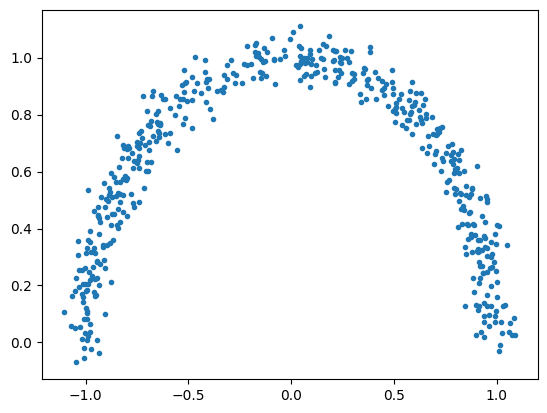

In [ ]:
# Plot dataset points
import matplotlib.pyplot as plt

sampled = np.array([half_circle()[0].tolist() for i in range(500)])
plt.plot(sampled[:,0], sampled[:,1], '.')
plt.show()

In [ ]:
# training
trainingdata = data.DataLoader(half_circle(n=1000), batch_size=64)

model = INN.Sequential(INN.BatchNorm1d(2), INN.Nonlinear(2, 'RealNVP'), INN.JacobianLinear(2),
                       INN.BatchNorm1d(2), INN.Nonlinear(2, 'RealNVP'), INN.JacobianLinear(2),
                       INN.BatchNorm1d(2), INN.Nonlinear(2, 'RealNVP'), INN.JacobianLinear(2),
                       INN.BatchNorm1d(2), INN.Nonlinear(2, 'RealNVP'), INN.JacobianLinear(2),
                       INN.BatchNorm1d(2), INN.Nonlinear(2, 'RealNVP'), INN.JacobianLinear(2), INN.ResizeFeatures(2, 1))

model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prior distribution of output
p = INN.utilities.NormalDistribution()

loss_count = []
for i in range(50):
    losses = []
    for x in trainingdata:
        optimizer.zero_grad()
        y, logp, logdet = model(x)
        py = p.logp(y)

        loss = py + logp + logdet
        loss = -1 * loss.mean()

        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    loss_count.append(np.mean(losses))
    print(sum(losses) / len(losses))

0.7673046067357063


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 17>:27                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/_tensor.py:488 in backward                         │
│                                                                                                  │
│    485 │   │   │   │   create_graph=create_graph,                                                │
│    486 │   │   │   │   inputs=inputs,                                                            │
│    487 │   │   │   )                                                                             │
│ ❱  488 │   │   torch.autograd.backward(                                                          │
│    489 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    490 │   │   )                                                                                 │
│    491                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:197 in backward               │
│                                                                                                  │
│   194 │   # The reason we repeat same the comment below is that                                  │
│   195 │   # some Python versions print out the first line of a multi-line function               │
│   196 │   # calls in the traceback and some print out the last line                              │
│ ❱ 197 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the bac   │
│   198 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                        │
│   199 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to ru   │
│   200                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [ ]:
# plot training results
inn_sampled = model.inverse(torch.randn(500, 1)).detach()

plt.plot(sampled[:,0], sampled[:,1], '.', label='sampled')
plt.plot(inn_sampled[:,0], inn_sampled[:,1], '.', label='INN sampled')
plt.legend()
plt.show()

In [ ]:
plt.plot(loss_count, '.-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training loss record')
plt.show()